In [1]:
import os

folder_path = "/Users/ramonjr.comendador/cs198-protein-folding/datasets"

csv_files = [f for f in os.listdir(folder_path) if (f.endswith('.csv') and not f.endswith('5.csv'))][:]

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [3]:
# FUNCTION FOR INTERPOLATING MATRIX

def interpolate_matrix(matrix, scale_factor):
    interpolated_matrix = scipy.ndimage.zoom(matrix, zoom=scale_factor, order=3)  # cubic interpolation (order=3)
    
    return interpolated_matrix

In [4]:
# CONVERT CSV TO MATRICES

def csv_to_3D_matrix(folder_path, csv_files):
    """
    Converts a list of CSV files into a 3D matrix where each CSV contributes
    a 2D matrix of values based on the 'x', 'y', and 'Value' columns.
    
    Parameters:
    - folder_path (str): The folder where the CSV files are located.
    - csv_files (list): A list of CSV file names to process.
    
    Returns:
    - list: A list of 2D matrices, each corresponding to a CSV file.
    """
    csv_to_3Dmatrix = []

    for csv_file in csv_files:
        # Load the CSV file
        energy_levels = pd.read_csv(os.path.join(folder_path, csv_file), header=None, names=['x', 'y', 'Value'])

        # Get unique x and y values
        unique_x = energy_levels['x'].unique()
        unique_y = energy_levels['y'].unique()

        # Create index mappings for x and y values
        x_index = {val: idx for idx, val in enumerate(unique_x)}
        y_index = {val: idx for idx, val in enumerate(unique_y)}

        # Initialize a matrix filled with NaNs
        matrix = np.full((len(unique_y), len(unique_x)), np.nan)

        # Fill the matrix with values from the CSV
        for _, row in energy_levels.iterrows():
            x_pos = x_index[row['x']]
            y_pos = y_index[row['y']]
            matrix[y_pos, x_pos] = row['Value']

        # Interpolate the matrix by scale factor of 10
        interpolated_matrix = interpolate_matrix(matrix=matrix, scale_factor=10)

        # print("Matrix shape: ", matrix.shape)
        # print("Interpolated Matrix shape: ", interpolated_matrix.shape)

        # Append the matrix to the list
        # csv_to_3Dmatrix.append(matrix)
        csv_to_3Dmatrix.append(interpolated_matrix)
    
    return csv_to_3Dmatrix


In [5]:
# LOCATING LOCAL MINIMA FUNCTION

def find_local_minima(matrix):
    rows, cols = matrix.shape
    local_minima = []

    def get_neighbors(x, y):
        """Get the 8 neighbors of a point (x, y) with wrap-around."""
        neighbors = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                # Apply wrap-around using modulo operator
                nx = (x + dx) % rows
                ny = (y + dy) % cols
                neighbors.append((nx, ny))
        return neighbors

    def is_local_minimum(x, y):
        """Check if (x, y) is a local minimum considering its neighbors."""
        value = matrix[x, y]
        neighbors = get_neighbors(x, y)
        for nx, ny in neighbors:
            if matrix[nx, ny] < value:
                return False
        return True

    def get_flat_region(x, y, visited):
        """Get all points in the flat region starting from (x, y)."""
        flat_points = [(x, y)]
        visited.add((x, y))
        value = matrix[x, y]
        stack = [(x, y)]
        while stack:
            cx, cy = stack.pop()
            neighbors = get_neighbors(cx, cy)
            for nx, ny in neighbors:
                if (nx, ny) not in visited and matrix[nx, ny] == value:
                    visited.add((nx, ny))
                    flat_points.append((nx, ny))
                    stack.append((nx, ny))
        return flat_points

    visited = set()

    for x in range(rows):
        for y in range(cols):
            if (x, y) in visited:
                continue
            
            if is_local_minimum(x, y):
                flat_region = get_flat_region(x, y, visited)
                if len(flat_region) > 1:
                    # Find the middle point of the flat region
                    flat_region = np.array(flat_region)
                    mid_idx = len(flat_region) // 2
                    middle_point = tuple(flat_region[mid_idx])
                    local_minima.append(middle_point)
                else:
                    local_minima.append((x, y))

    return local_minima

# Example usage with a random matrix
# local_minima = find_local_minima()
# print("Local minima:", local_minima)


In [6]:
# LOCATING LOCAL MAXIMA FUNCTION

def find_local_maxima(matrix):
    rows, cols = matrix.shape
    local_minima = []

    def get_neighbors(x, y):
        """Get the 8 neighbors of a point (x, y) with wrap-around."""
        neighbors = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                # Apply wrap-around using modulo operator
                nx = (x + dx) % rows
                ny = (y + dy) % cols
                neighbors.append((nx, ny))
        return neighbors

    def is_local_maximum(x, y):
        """Check if (x, y) is a local maximum considering its neighbors."""
        value = matrix[x, y]
        neighbors = get_neighbors(x, y)
        for nx, ny in neighbors:
            if matrix[nx, ny] > value:
                return False
        return True

    def get_flat_region(x, y, visited):
        """Get all points in the flat region starting from (x, y)."""
        flat_points = [(x, y)]
        visited.add((x, y))
        value = matrix[x, y]
        stack = [(x, y)]
        while stack:
            cx, cy = stack.pop()
            neighbors = get_neighbors(cx, cy)
            for nx, ny in neighbors:
                if (nx, ny) not in visited and matrix[nx, ny] == value:
                    visited.add((nx, ny))
                    flat_points.append((nx, ny))
                    stack.append((nx, ny))
        return flat_points

    visited = set()

    for x in range(rows):
        for y in range(cols):
            if (x, y) in visited:
                continue
            
            if is_local_maximum(x, y):
                flat_region = get_flat_region(x, y, visited)
                if len(flat_region) > 1:
                    # Find the middle point of the flat region
                    flat_region = np.array(flat_region)
                    mid_idx = len(flat_region) // 2
                    middle_point = tuple(flat_region[mid_idx])
                    local_minima.append(middle_point)
                else:
                    local_minima.append((x, y))

    return local_minima

# Example usage with a random matrix
# local_minima = find_local_minima()
# print("Local minima:", local_minima)


In [9]:
import heapq
import math

# A* with wrap-around on a 3D surface (NxN matrix) with heights
def a_star_wrap_around_surface(surface, start, goal):
    rows, cols = len(surface), len(surface[0])
    
    # Directions: Up, Down, Left, Right, and 4 Diagonals
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), 
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]  # Including diagonals

    def get_neighbors(node):
        x, y = node
        neighbors = []
        for dx, dy in directions:
            nx, ny = (x + dx) % rows, (y + dy) % cols  # Wrap-around using modulo
            neighbors.append((nx, ny))
        return neighbors

    def heuristic(node1, node2):
        x1, y1 = node1
        x2, y2 = node2
        h1 = surface[x1][y1]
        h2 = surface[x2][y2]
        # Wrap-around Euclidean distance heuristic, considering height
        dx = min(abs(x1 - x2), rows - abs(x1 - x2))
        dy = min(abs(y1 - y2), cols - abs(y1 - y2))
        dz = abs(h1 - h2)
        return math.sqrt(dx ** 2 + dy ** 2 + dz ** 2)

    def distance(current, neighbor):
        # Euclidean distance between two points, considering height difference
        x1, y1 = current
        x2, y2 = neighbor
        dx = min(abs(x1 - x2), rows - abs(x1 - x2))
        dy = min(abs(y1 - y2), cols - abs(y1 - y2))
        dz = abs(surface[x1][y1] - surface[x2][y2])
        return math.sqrt(dx ** 2 + dy ** 2 + dz ** 2)

    open_list = []
    heapq.heappush(open_list, (0, start))  # Priority queue (f-cost, node)
    came_from = {}
    g_score = {start: 0}
    
    while open_list:
        _, current = heapq.heappop(open_list)
        
        if current == goal:
            # Reconstruct the path
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return path
        
        for neighbor in get_neighbors(current):
            tentative_g_score = g_score[current] + distance(current, neighbor)
            
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(open_list, (f_score, neighbor))
    
    return None  # Return None if no path is found

# Example usage:
# A 5x5 grid where each value represents a height (z-coordinate) of a 3D surface
surface = [
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [1, 2, 3, 4, 5]
]
start = (0, 0)
goal = (4, 4)
path = a_star_wrap_around_surface(surface, start, goal)
print("Path found:", path)


Path found: [(4, 4)]


start:  (249, 15)
goal:  (150, 249)
[(248, 14), (247, 13), (246, 12), (245, 11), (244, 10), (243, 9), (242, 8), (241, 7), (240, 6), (239, 5), (238, 4), (237, 4), (236, 4), (235, 4), (234, 4), (233, 4), (232, 4), (231, 4), (230, 4), (229, 4), (228, 4), (227, 4), (226, 4), (225, 4), (224, 4), (223, 4), (222, 4), (221, 4), (220, 4), (219, 4), (218, 4), (217, 4), (216, 4), (215, 4), (214, 4), (213, 4), (212, 4), (211, 4), (210, 4), (209, 4), (208, 4), (207, 4), (206, 4), (205, 4), (204, 4), (203, 4), (202, 4), (201, 4), (200, 4), (199, 4), (198, 4), (197, 4), (196, 4), (195, 4), (194, 4), (193, 4), (192, 4), (191, 4), (190, 4), (189, 4), (188, 4), (187, 4), (186, 4), (185, 4), (184, 4), (183, 4), (182, 4), (181, 4), (180, 4), (179, 4), (178, 4), (177, 4), (176, 4), (175, 4), (174, 4), (173, 4), (172, 4), (171, 4), (170, 4), (169, 4), (168, 4), (167, 3), (166, 2), (165, 1), (164, 0), (163, 0), (162, 0), (161, 0), (160, 0), (159, 0), (158, 0), (157, 0), (156, 0), (155, 249), (154, 249), (153

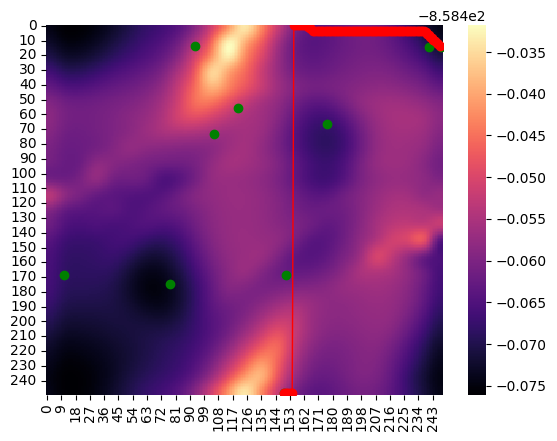

start:  (0, 17)
goal:  (174, 66)
[(249, 18), (248, 19), (247, 20), (246, 21), (245, 22), (244, 23), (243, 24), (242, 25), (241, 26), (240, 27), (239, 28), (238, 29), (237, 30), (236, 31), (235, 32), (234, 33), (233, 34), (232, 35), (231, 36), (230, 37), (229, 38), (228, 39), (227, 40), (226, 41), (225, 42), (224, 43), (223, 44), (222, 45), (221, 46), (220, 47), (219, 48), (218, 49), (217, 50), (216, 51), (215, 51), (214, 51), (213, 51), (212, 51), (211, 51), (210, 51), (209, 52), (208, 53), (207, 54), (206, 55), (205, 56), (204, 57), (203, 58), (202, 59), (201, 60), (200, 60), (199, 60), (198, 60), (197, 60), (196, 60), (195, 60), (194, 60), (193, 60), (192, 60), (191, 60), (190, 60), (189, 60), (188, 60), (187, 60), (186, 60), (185, 60), (184, 60), (183, 60), (182, 60), (181, 60), (180, 60), (179, 61), (178, 62), (177, 63), (176, 64), (175, 65), (174, 66)]
start:  (0, 17)
goal:  (174, 66)
[(249, 18), (248, 19), (247, 20), (246, 21), (245, 22), (244, 23), (243, 24), (242, 25), (241, 26

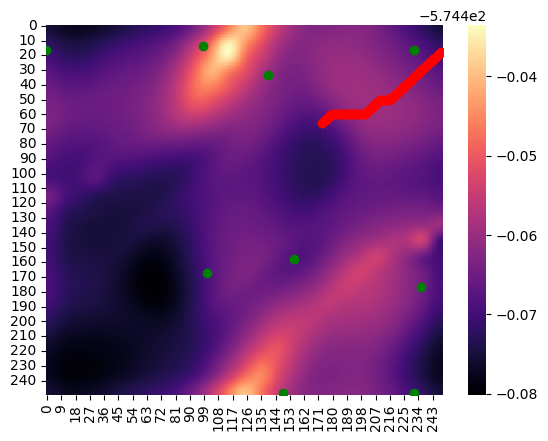

start:  (0, 15)
goal:  (149, 249)
[(249, 15), (248, 15), (247, 15), (246, 15), (245, 15), (244, 15), (243, 15), (242, 15), (241, 15), (240, 15), (239, 15), (238, 15), (237, 15), (236, 15), (235, 15), (234, 15), (233, 15), (232, 15), (231, 15), (230, 15), (229, 15), (228, 15), (227, 15), (226, 15), (225, 15), (224, 15), (223, 15), (222, 15), (221, 15), (220, 15), (219, 15), (218, 15), (217, 15), (216, 15), (215, 15), (214, 15), (213, 15), (212, 15), (211, 15), (210, 15), (209, 15), (208, 15), (207, 15), (206, 15), (205, 15), (204, 15), (203, 15), (202, 15), (201, 15), (200, 15), (199, 15), (198, 15), (197, 15), (196, 15), (195, 15), (194, 15), (193, 15), (192, 15), (191, 15), (190, 15), (189, 15), (188, 15), (187, 15), (186, 15), (185, 15), (184, 15), (183, 15), (182, 15), (181, 15), (180, 15), (179, 15), (178, 15), (177, 15), (176, 15), (175, 15), (174, 15), (173, 15), (172, 15), (171, 15), (170, 14), (169, 13), (168, 12), (167, 11), (166, 10), (165, 9), (164, 8), (163, 7), (162, 6), (

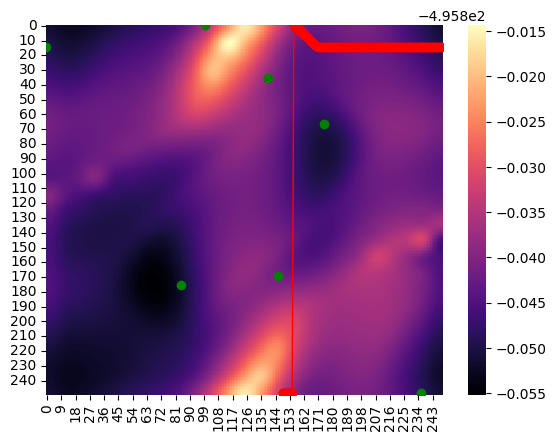

start:  (0, 14)
goal:  (175, 67)
[(249, 15), (248, 16), (247, 17), (246, 18), (245, 19), (244, 20), (243, 21), (242, 22), (241, 23), (240, 24), (239, 25), (238, 26), (237, 27), (236, 28), (235, 29), (234, 30), (233, 31), (232, 32), (231, 33), (230, 34), (229, 34), (228, 34), (227, 34), (226, 34), (225, 34), (224, 34), (223, 34), (222, 34), (221, 34), (220, 34), (219, 34), (218, 34), (217, 34), (216, 35), (215, 36), (214, 37), (213, 38), (212, 39), (211, 40), (210, 41), (209, 42), (208, 43), (207, 44), (206, 45), (205, 46), (204, 47), (203, 48), (202, 49), (201, 50), (200, 51), (199, 52), (198, 53), (197, 54), (196, 55), (195, 56), (194, 57), (193, 58), (192, 59), (191, 59), (190, 59), (189, 59), (188, 59), (187, 59), (186, 59), (185, 59), (184, 59), (183, 59), (182, 60), (181, 61), (180, 62), (179, 63), (178, 64), (177, 65), (176, 66), (175, 67)]
start:  (0, 14)
goal:  (175, 67)
[(249, 15), (248, 16), (247, 17), (246, 18), (245, 19), (244, 20), (243, 21), (242, 22), (241, 23), (240, 24

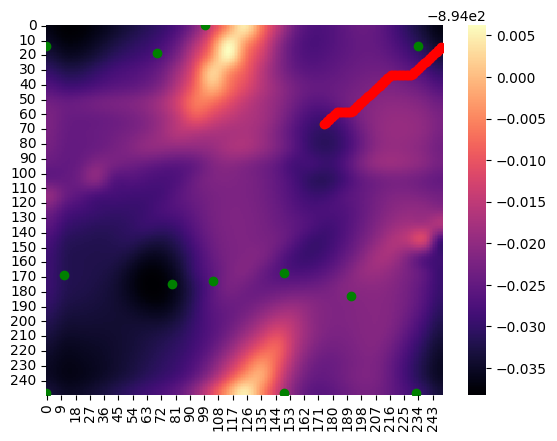

start:  (0, 16)
goal:  (139, 38)
[(249, 17), (248, 17), (247, 17), (246, 17), (245, 17), (244, 17), (243, 17), (242, 17), (241, 17), (240, 17), (239, 17), (238, 17), (237, 17), (236, 17), (235, 17), (234, 17), (233, 18), (232, 19), (231, 20), (230, 21), (229, 22), (228, 23), (227, 24), (226, 25), (225, 26), (224, 27), (223, 28), (222, 29), (221, 30), (220, 31), (219, 32), (218, 33), (217, 34), (216, 35), (215, 36), (214, 37), (213, 38), (212, 38), (211, 38), (210, 38), (209, 38), (208, 38), (207, 38), (206, 38), (205, 38), (204, 38), (203, 38), (202, 38), (201, 38), (200, 38), (199, 38), (198, 38), (197, 38), (196, 38), (195, 38), (194, 38), (193, 38), (192, 38), (191, 38), (190, 38), (189, 38), (188, 38), (187, 38), (186, 38), (185, 38), (184, 38), (183, 38), (182, 38), (181, 38), (180, 38), (179, 38), (178, 38), (177, 38), (176, 38), (175, 38), (174, 38), (173, 38), (172, 38), (171, 38), (170, 38), (169, 38), (168, 38), (167, 38), (166, 38), (165, 38), (164, 38), (163, 38), (162, 38)

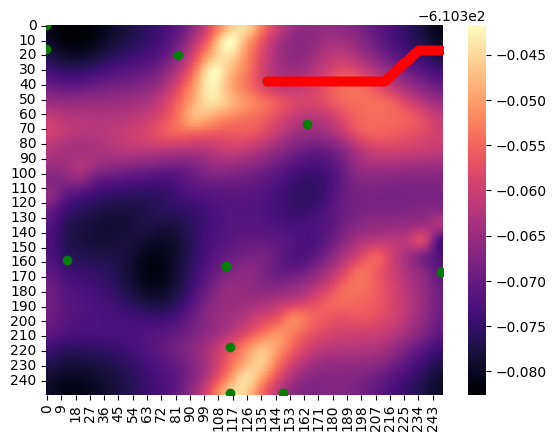

start:  (0, 15)
goal:  (177, 67)
[(249, 16), (248, 17), (247, 18), (246, 19), (245, 20), (244, 21), (243, 22), (242, 23), (241, 24), (240, 25), (239, 26), (238, 27), (237, 28), (236, 29), (235, 30), (234, 31), (233, 32), (232, 33), (231, 34), (230, 35), (229, 36), (228, 37), (227, 38), (226, 39), (225, 40), (224, 41), (223, 42), (222, 43), (221, 44), (220, 45), (219, 46), (218, 47), (217, 48), (216, 49), (215, 50), (214, 51), (213, 52), (212, 53), (211, 54), (210, 55), (209, 56), (208, 57), (207, 58), (206, 59), (205, 60), (204, 61), (203, 62), (202, 63), (201, 64), (200, 65), (199, 66), (198, 67), (197, 67), (196, 67), (195, 67), (194, 67), (193, 67), (192, 67), (191, 67), (190, 67), (189, 67), (188, 67), (187, 67), (186, 67), (185, 67), (184, 67), (183, 67), (182, 67), (181, 67), (180, 67), (179, 67), (178, 67), (177, 67)]
start:  (0, 15)
goal:  (177, 67)
[(249, 16), (248, 17), (247, 18), (246, 19), (245, 20), (244, 21), (243, 22), (242, 23), (241, 24), (240, 25), (239, 26), (238, 27

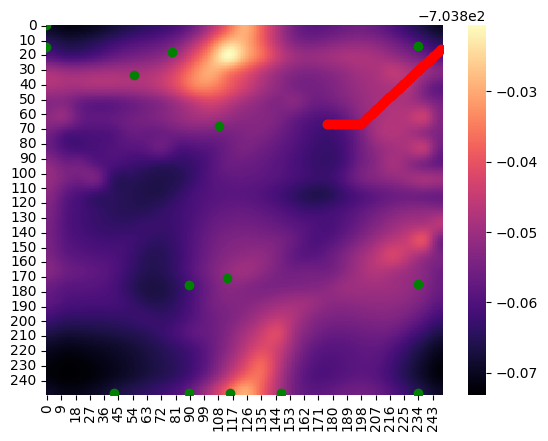

start:  (0, 15)
goal:  (150, 249)
[(249, 15), (248, 14), (247, 13), (246, 12), (245, 11), (244, 10), (243, 9), (242, 8), (241, 7), (240, 6), (239, 5), (238, 4), (237, 4), (236, 4), (235, 4), (234, 4), (233, 4), (232, 4), (231, 4), (230, 4), (229, 4), (228, 4), (227, 4), (226, 4), (225, 4), (224, 4), (223, 4), (222, 4), (221, 4), (220, 4), (219, 4), (218, 4), (217, 4), (216, 4), (215, 4), (214, 4), (213, 4), (212, 4), (211, 4), (210, 4), (209, 4), (208, 4), (207, 4), (206, 4), (205, 4), (204, 4), (203, 4), (202, 4), (201, 4), (200, 4), (199, 4), (198, 4), (197, 4), (196, 4), (195, 4), (194, 4), (193, 4), (192, 4), (191, 4), (190, 4), (189, 4), (188, 4), (187, 4), (186, 4), (185, 4), (184, 4), (183, 4), (182, 4), (181, 4), (180, 4), (179, 4), (178, 4), (177, 4), (176, 4), (175, 4), (174, 4), (173, 4), (172, 4), (171, 4), (170, 4), (169, 4), (168, 4), (167, 4), (166, 4), (165, 4), (164, 4), (163, 3), (162, 2), (161, 1), (160, 0), (159, 0), (158, 0), (157, 0), (156, 0), (155, 249), (154, 2

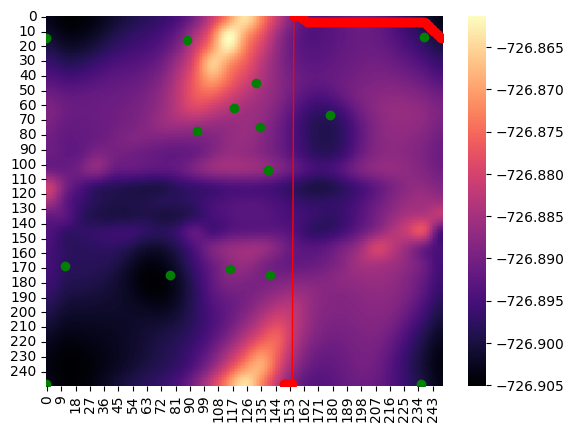

start:  (0, 0)
goal:  (109, 210)
[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 249), (8, 248), (9, 247), (10, 246), (11, 245), (12, 244), (13, 243), (14, 242), (15, 241), (16, 240), (17, 239), (18, 238), (19, 237), (20, 236), (21, 235), (22, 234), (23, 233), (24, 232), (25, 231), (26, 230), (27, 229), (28, 228), (29, 227), (30, 226), (31, 225), (32, 224), (33, 223), (34, 222), (35, 221), (36, 220), (37, 219), (38, 218), (39, 217), (40, 216), (41, 215), (42, 214), (43, 213), (44, 212), (45, 211), (46, 210), (47, 210), (48, 210), (49, 210), (50, 210), (51, 210), (52, 210), (53, 210), (54, 210), (55, 210), (56, 210), (57, 210), (58, 210), (59, 210), (60, 210), (61, 210), (62, 210), (63, 210), (64, 210), (65, 210), (66, 210), (67, 210), (68, 210), (69, 210), (70, 210), (71, 210), (72, 210), (73, 210), (74, 210), (75, 210), (76, 210), (77, 210), (78, 210), (79, 210), (80, 210), (81, 210), (82, 210), (83, 210), (84, 210), (85, 210), (86, 210), (87, 210), (88, 210), (89, 210), (90, 210

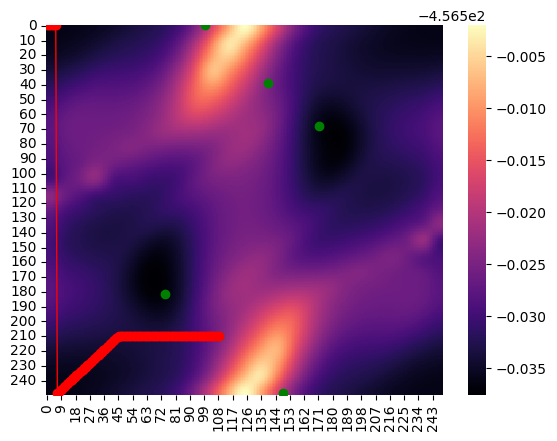

start:  (0, 0)
goal:  (169, 249)
[(249, 0), (248, 0), (247, 0), (246, 0), (245, 0), (244, 0), (243, 0), (242, 0), (241, 249), (240, 249), (239, 249), (238, 249), (237, 249), (236, 249), (235, 249), (234, 249), (233, 249), (232, 249), (231, 249), (230, 249), (229, 249), (228, 249), (227, 249), (226, 249), (225, 249), (224, 249), (223, 249), (222, 249), (221, 249), (220, 249), (219, 249), (218, 249), (217, 249), (216, 249), (215, 249), (214, 249), (213, 249), (212, 249), (211, 249), (210, 249), (209, 249), (208, 249), (207, 249), (206, 249), (205, 249), (204, 249), (203, 249), (202, 249), (201, 249), (200, 249), (199, 249), (198, 249), (197, 249), (196, 249), (195, 249), (194, 249), (193, 249), (192, 249), (191, 249), (190, 249), (189, 249), (188, 249), (187, 249), (186, 249), (185, 249), (184, 249), (183, 249), (182, 249), (181, 249), (180, 249), (179, 249), (178, 249), (177, 249), (176, 249), (175, 249), (174, 249), (173, 249), (172, 249), (171, 249), (170, 249), (169, 249)]
start:  (0

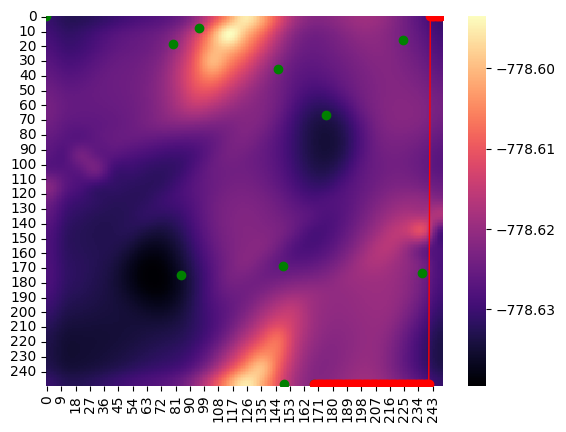

start:  (0, 29)
goal:  (150, 249)
[(249, 28), (248, 27), (247, 26), (246, 26), (245, 26), (244, 26), (243, 26), (242, 25), (241, 25), (240, 25), (239, 25), (238, 25), (237, 25), (236, 25), (235, 25), (234, 25), (233, 25), (232, 25), (231, 25), (230, 25), (229, 25), (228, 25), (227, 25), (226, 25), (225, 25), (224, 25), (223, 25), (222, 25), (221, 25), (220, 25), (219, 25), (218, 25), (217, 25), (216, 25), (215, 25), (214, 25), (213, 25), (212, 25), (211, 25), (210, 25), (209, 25), (208, 25), (207, 25), (206, 25), (205, 25), (204, 25), (203, 25), (202, 25), (201, 25), (200, 25), (199, 25), (198, 25), (197, 25), (196, 25), (195, 25), (194, 25), (193, 25), (192, 25), (191, 25), (190, 25), (189, 25), (188, 25), (187, 25), (186, 25), (185, 25), (184, 25), (183, 25), (182, 25), (181, 24), (180, 23), (179, 22), (178, 21), (177, 20), (176, 19), (175, 18), (174, 17), (173, 16), (172, 15), (171, 14), (170, 13), (169, 12), (168, 11), (167, 10), (166, 9), (165, 8), (164, 7), (163, 6), (162, 5), (1

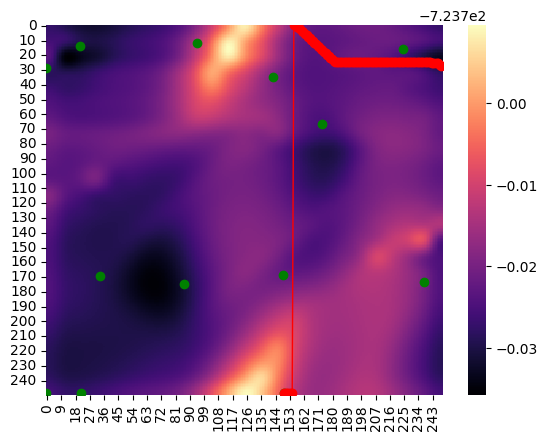

start:  (0, 13)
goal:  (150, 249)
[(249, 12), (248, 12), (247, 12), (246, 12), (245, 12), (244, 12), (243, 12), (242, 12), (241, 12), (240, 12), (239, 12), (238, 12), (237, 12), (236, 12), (235, 12), (234, 12), (233, 12), (232, 12), (231, 12), (230, 12), (229, 12), (228, 12), (227, 12), (226, 12), (225, 12), (224, 12), (223, 12), (222, 12), (221, 12), (220, 12), (219, 12), (218, 12), (217, 12), (216, 12), (215, 12), (214, 12), (213, 12), (212, 12), (211, 12), (210, 12), (209, 12), (208, 12), (207, 12), (206, 12), (205, 12), (204, 12), (203, 12), (202, 12), (201, 12), (200, 12), (199, 12), (198, 12), (197, 12), (196, 12), (195, 12), (194, 12), (193, 12), (192, 12), (191, 12), (190, 12), (189, 12), (188, 12), (187, 12), (186, 12), (185, 12), (184, 12), (183, 12), (182, 12), (181, 12), (180, 12), (179, 12), (178, 12), (177, 12), (176, 12), (175, 12), (174, 12), (173, 12), (172, 11), (171, 10), (170, 9), (169, 8), (168, 7), (167, 6), (166, 5), (165, 4), (164, 3), (163, 2), (162, 1), (161, 

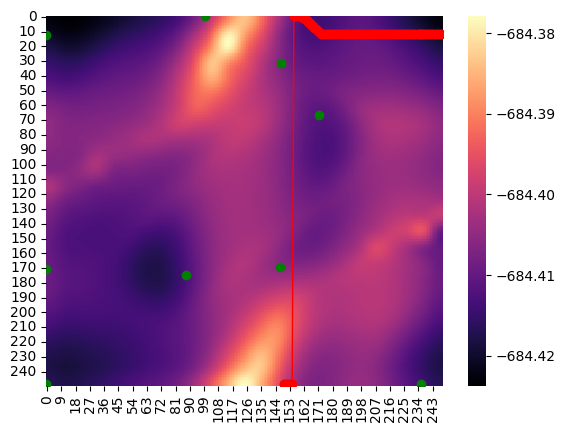

start:  (3, 249)
goal:  (151, 249)
[(2, 249), (1, 249), (0, 249), (249, 249), (248, 249), (247, 249), (246, 249), (245, 249), (244, 249), (243, 249), (242, 249), (241, 249), (240, 249), (239, 249), (238, 249), (237, 249), (236, 249), (235, 249), (234, 249), (233, 249), (232, 249), (231, 249), (230, 249), (229, 249), (228, 249), (227, 249), (226, 249), (225, 249), (224, 249), (223, 249), (222, 249), (221, 249), (220, 249), (219, 249), (218, 249), (217, 249), (216, 249), (215, 249), (214, 249), (213, 249), (212, 249), (211, 249), (210, 249), (209, 249), (208, 249), (207, 249), (206, 249), (205, 249), (204, 249), (203, 249), (202, 249), (201, 249), (200, 249), (199, 249), (198, 249), (197, 249), (196, 249), (195, 249), (194, 249), (193, 249), (192, 249), (191, 249), (190, 249), (189, 249), (188, 249), (187, 249), (186, 249), (185, 249), (184, 249), (183, 249), (182, 249), (181, 249), (180, 249), (179, 249), (178, 249), (177, 249), (176, 249), (175, 249), (174, 249), (173, 249), (172, 249)

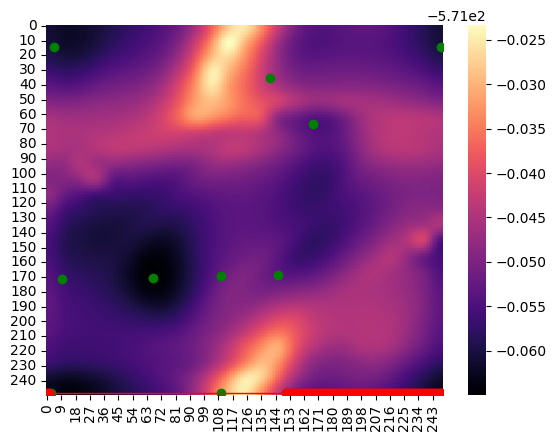

start:  (0, 17)
goal:  (174, 66)
[(249, 18), (248, 19), (247, 20), (246, 21), (245, 22), (244, 23), (243, 24), (242, 25), (241, 26), (240, 27), (239, 28), (238, 29), (237, 30), (236, 31), (235, 32), (234, 33), (233, 34), (232, 35), (231, 36), (230, 37), (229, 38), (228, 39), (227, 40), (226, 41), (225, 42), (224, 43), (223, 44), (222, 45), (221, 46), (220, 47), (219, 48), (218, 49), (217, 50), (216, 50), (215, 50), (214, 50), (213, 50), (212, 50), (211, 50), (210, 50), (209, 50), (208, 51), (207, 52), (206, 53), (205, 54), (204, 55), (203, 56), (202, 57), (201, 58), (200, 59), (199, 60), (198, 60), (197, 60), (196, 60), (195, 60), (194, 60), (193, 60), (192, 60), (191, 60), (190, 60), (189, 60), (188, 60), (187, 60), (186, 60), (185, 60), (184, 60), (183, 60), (182, 60), (181, 60), (180, 60), (179, 61), (178, 62), (177, 63), (176, 64), (175, 65), (174, 66)]
start:  (0, 17)
goal:  (174, 66)
[(249, 18), (248, 19), (247, 20), (246, 21), (245, 22), (244, 23), (243, 24), (242, 25), (241, 26

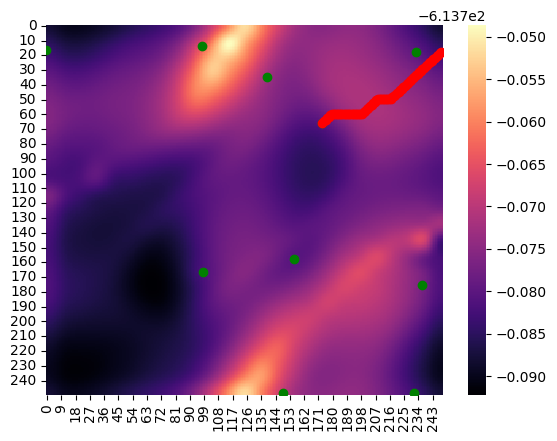

start:  (0, 249)
goal:  (151, 169)
[(249, 248), (248, 247), (247, 246), (246, 245), (245, 244), (244, 243), (243, 242), (242, 241), (241, 240), (240, 239), (239, 238), (238, 237), (237, 236), (236, 235), (235, 234), (234, 233), (233, 232), (232, 231), (231, 230), (230, 229), (229, 228), (228, 227), (227, 226), (226, 225), (225, 224), (224, 223), (223, 222), (222, 221), (221, 220), (220, 219), (219, 218), (218, 217), (217, 216), (216, 215), (215, 214), (214, 213), (213, 212), (212, 211), (211, 210), (210, 209), (209, 208), (208, 207), (207, 206), (206, 205), (205, 204), (204, 203), (203, 202), (202, 201), (201, 200), (200, 199), (199, 198), (198, 197), (197, 196), (196, 195), (195, 194), (194, 193), (193, 192), (192, 191), (191, 190), (190, 189), (189, 188), (188, 187), (187, 186), (186, 185), (185, 184), (184, 183), (183, 182), (182, 181), (181, 180), (180, 179), (179, 178), (178, 177), (177, 176), (176, 176), (175, 176), (174, 176), (173, 176), (172, 176), (171, 176), (170, 176), (169

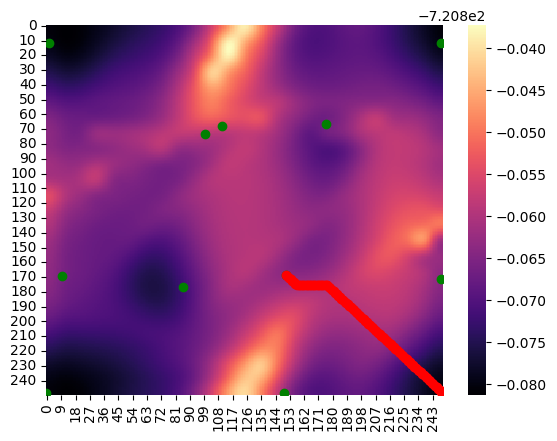

start:  (249, 16)
goal:  (150, 249)
[(248, 15), (247, 14), (246, 13), (245, 12), (244, 11), (243, 10), (242, 9), (241, 8), (240, 7), (239, 6), (238, 5), (237, 4), (236, 3), (235, 2), (234, 1), (233, 1), (232, 1), (231, 1), (230, 1), (229, 1), (228, 1), (227, 1), (226, 1), (225, 1), (224, 1), (223, 1), (222, 1), (221, 1), (220, 1), (219, 1), (218, 1), (217, 1), (216, 1), (215, 1), (214, 1), (213, 1), (212, 1), (211, 1), (210, 1), (209, 1), (208, 1), (207, 1), (206, 1), (205, 1), (204, 1), (203, 1), (202, 1), (201, 1), (200, 1), (199, 1), (198, 1), (197, 1), (196, 1), (195, 1), (194, 1), (193, 1), (192, 1), (191, 1), (190, 1), (189, 1), (188, 1), (187, 1), (186, 1), (185, 1), (184, 1), (183, 1), (182, 1), (181, 1), (180, 1), (179, 1), (178, 1), (177, 1), (176, 1), (175, 1), (174, 1), (173, 1), (172, 1), (171, 1), (170, 1), (169, 1), (168, 1), (167, 1), (166, 1), (165, 0), (164, 0), (163, 0), (162, 0), (161, 0), (160, 0), (159, 0), (158, 0), (157, 0), (156, 0), (155, 249), (154, 249), (15

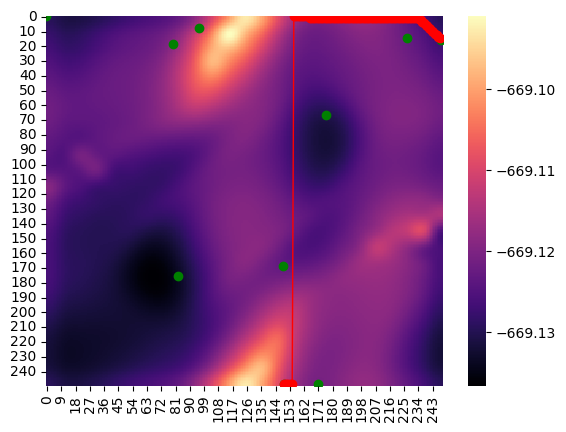

start:  (0, 15)
goal:  (150, 249)
[(249, 15), (248, 15), (247, 15), (246, 15), (245, 15), (244, 15), (243, 15), (242, 15), (241, 15), (240, 15), (239, 15), (238, 15), (237, 15), (236, 15), (235, 15), (234, 15), (233, 15), (232, 15), (231, 15), (230, 15), (229, 15), (228, 15), (227, 15), (226, 15), (225, 15), (224, 15), (223, 15), (222, 15), (221, 15), (220, 15), (219, 15), (218, 15), (217, 15), (216, 15), (215, 15), (214, 15), (213, 15), (212, 15), (211, 15), (210, 15), (209, 15), (208, 15), (207, 15), (206, 15), (205, 15), (204, 15), (203, 15), (202, 15), (201, 15), (200, 15), (199, 15), (198, 15), (197, 15), (196, 15), (195, 15), (194, 15), (193, 15), (192, 15), (191, 15), (190, 15), (189, 15), (188, 15), (187, 15), (186, 15), (185, 15), (184, 15), (183, 15), (182, 15), (181, 15), (180, 15), (179, 15), (178, 15), (177, 15), (176, 15), (175, 15), (174, 15), (173, 15), (172, 14), (171, 13), (170, 12), (169, 11), (168, 10), (167, 9), (166, 8), (165, 7), (164, 6), (163, 5), (162, 4), (16

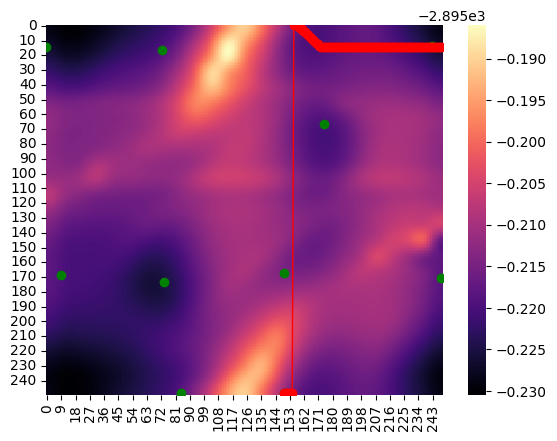

start:  (11, 169)
goal:  (179, 67)
[(10, 168), (9, 167), (8, 166), (7, 165), (6, 164), (5, 163), (4, 162), (3, 161), (2, 160), (1, 159), (0, 158), (249, 157), (248, 156), (247, 155), (246, 154), (245, 153), (244, 152), (243, 151), (242, 150), (241, 149), (240, 148), (239, 147), (238, 146), (237, 145), (236, 144), (235, 143), (234, 142), (233, 141), (232, 140), (231, 139), (230, 138), (229, 137), (228, 136), (227, 135), (226, 134), (225, 133), (224, 132), (224, 131), (224, 130), (224, 129), (224, 128), (224, 127), (224, 126), (224, 125), (224, 124), (224, 123), (224, 122), (224, 121), (224, 120), (224, 119), (224, 118), (224, 117), (224, 116), (224, 115), (224, 114), (224, 113), (224, 112), (223, 111), (222, 110), (221, 109), (220, 108), (219, 107), (218, 106), (217, 105), (216, 104), (215, 103), (214, 102), (213, 101), (212, 100), (211, 99), (210, 98), (209, 97), (208, 96), (207, 95), (206, 94), (205, 93), (204, 92), (203, 91), (202, 90), (201, 89), (200, 88), (199, 87), (198, 86), (19

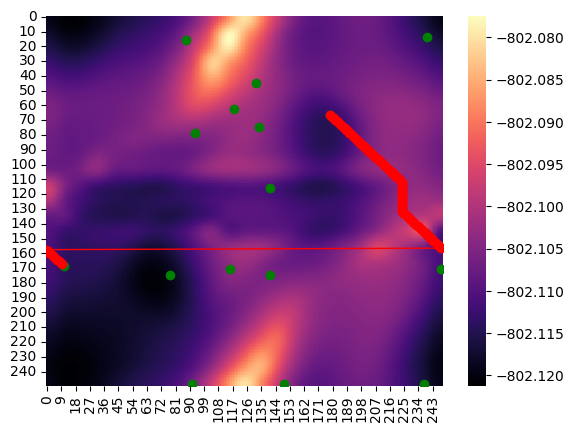

start:  (249, 172)
goal:  (173, 67)
[(248, 171), (247, 170), (246, 169), (245, 168), (244, 167), (243, 166), (242, 165), (241, 164), (240, 163), (239, 162), (238, 161), (237, 160), (236, 159), (235, 158), (234, 157), (233, 156), (232, 155), (231, 154), (230, 153), (229, 152), (228, 151), (227, 150), (226, 149), (225, 148), (224, 147), (223, 146), (222, 145), (221, 144), (220, 143), (219, 142), (218, 141), (217, 140), (216, 139), (215, 138), (214, 137), (214, 136), (214, 135), (214, 134), (214, 133), (214, 132), (214, 131), (214, 130), (214, 129), (214, 128), (214, 127), (214, 126), (214, 125), (214, 124), (214, 123), (214, 122), (214, 121), (214, 120), (214, 119), (214, 118), (214, 117), (214, 116), (214, 115), (214, 114), (214, 113), (214, 112), (214, 111), (214, 110), (214, 109), (214, 108), (213, 107), (212, 106), (211, 105), (210, 104), (209, 103), (208, 102), (207, 101), (206, 100), (205, 99), (204, 98), (203, 97), (202, 96), (201, 95), (200, 94), (199, 93), (198, 92), (197, 91), 

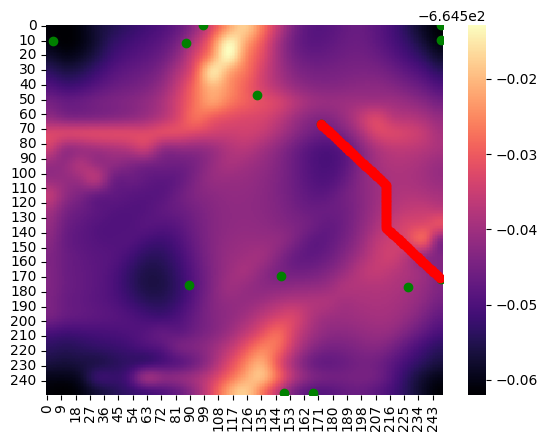

start:  (0, 48)
goal:  (227, 249)
[(249, 47), (248, 46), (247, 45), (246, 44), (245, 43), (245, 42), (245, 41), (245, 40), (245, 39), (245, 38), (245, 37), (245, 36), (245, 35), (245, 34), (245, 33), (245, 32), (245, 31), (245, 30), (245, 29), (245, 28), (245, 27), (245, 26), (245, 25), (245, 24), (245, 23), (245, 22), (245, 21), (245, 20), (245, 19), (245, 18), (245, 17), (244, 16), (243, 15), (242, 14), (241, 13), (240, 12), (239, 11), (238, 10), (237, 9), (236, 8), (235, 7), (234, 6), (233, 5), (232, 4), (231, 3), (230, 2), (229, 1), (228, 0), (227, 249)]
start:  (0, 48)
goal:  (227, 249)
[(249, 47), (248, 46), (247, 45), (246, 44), (245, 43), (245, 42), (245, 41), (245, 40), (245, 39), (245, 38), (245, 37), (245, 36), (245, 35), (245, 34), (245, 33), (245, 32), (245, 31), (245, 30), (245, 29), (245, 28), (245, 27), (245, 26), (245, 25), (245, 24), (245, 23), (245, 22), (245, 21), (245, 20), (245, 19), (245, 18), (245, 17), (244, 16), (243, 15), (242, 14), (241, 13), (240, 12), (239

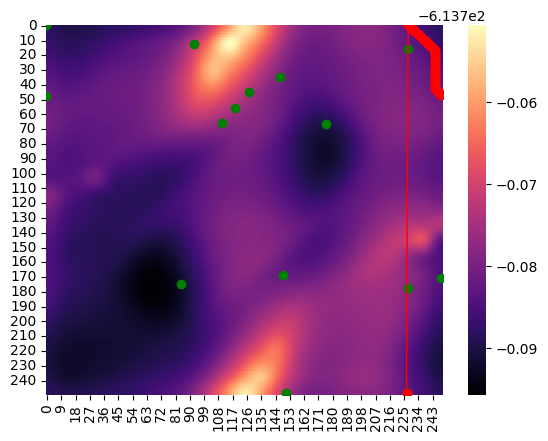

start:  (10, 167)
goal:  (175, 67)
[(9, 166), (8, 165), (7, 164), (6, 163), (5, 162), (4, 161), (3, 160), (2, 159), (1, 158), (0, 157), (249, 156), (248, 155), (247, 154), (246, 153), (245, 152), (244, 151), (243, 150), (242, 149), (241, 148), (240, 147), (239, 146), (238, 145), (237, 144), (236, 143), (235, 142), (234, 141), (233, 140), (232, 139), (231, 138), (230, 137), (229, 136), (228, 135), (227, 134), (226, 133), (225, 132), (224, 131), (224, 130), (224, 129), (224, 128), (224, 127), (224, 126), (224, 125), (224, 124), (224, 123), (224, 122), (224, 121), (224, 120), (224, 119), (224, 118), (224, 117), (224, 116), (223, 115), (222, 114), (221, 113), (220, 112), (219, 111), (218, 110), (217, 109), (216, 108), (215, 107), (214, 106), (213, 105), (212, 104), (211, 103), (210, 102), (209, 101), (208, 100), (207, 99), (206, 98), (205, 97), (204, 96), (203, 95), (202, 94), (201, 93), (200, 92), (199, 91), (198, 90), (197, 89), (196, 88), (195, 87), (194, 86), (193, 85), (192, 84), (191

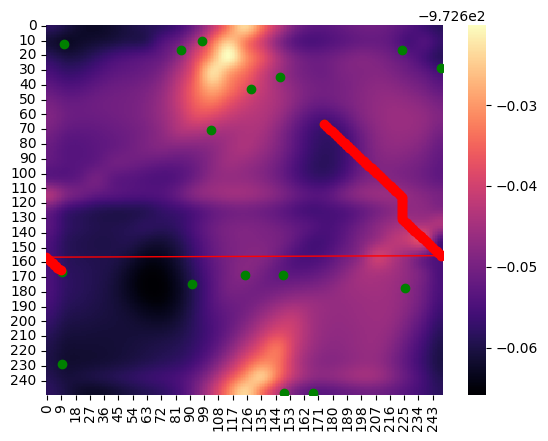

In [25]:
three_dim_matrices = csv_to_3D_matrix(folder_path=folder_path, csv_files=csv_files)
local_minima_per_matrix = [find_local_minima(i) for i in three_dim_matrices]
local_maxima_per_matrix = [find_local_maxima(i) for i in three_dim_matrices]

for i in range(len(three_dim_matrices)):
  # energy_levels = pd.read_csv(os.path.join(folder_path, csv_files[i]), header=None, names=['x', 'y', 'Value'])
  # heat_map = energy_levels.pivot(index='y', columns='x', values='Value')
  # sns.heatmap(heat_map, cmap='magma', annot=False, fmt=".1f")



  sns.heatmap(three_dim_matrices[i], cmap='magma', annot=False, fmt=".1f")
  for j in local_minima_per_matrix[i]:
    plt.scatter(x=j[0], y=j[1], color='green', marker='o')

    start2 = local_minima_per_matrix[i][0]
    goal2 = local_minima_per_matrix[i][-4]
    surface2 = three_dim_matrices[i]

    path = a_star_wrap_around_surface(surface=surface2, start=start2, goal=goal2)
    print("start: ", start2)
    print("goal: ", goal2)
    print(path)


  # for j in local_maxima_per_matrix[i]:
  #   plt.scatter(x=j[0], y=j[1], color='yellow', marker='o')



  # Separate the list into two lists: x-values and y-values
  x_values, y_values = zip(*path)

  # Create the plot
  plt.plot(x_values, y_values, marker='o', linewidth=1, color='red')

    
  
  plt.show()
